# Visualizing deep learning with galaxies, part 1
> Let's explore the morphological feature space of galaxies represented by a trained CNN. We will use PCA to reduce the dimensionality of the neural network's latent features, and then visualize these features with matplotlib.

- toc: true
- badges: true
- comments: true
- author: John F Wu
- categories: [galaxies, astrophysics, deep learning, visualization]
- image: images/visualizing-features-1.png



In [1]:
#hide
from fastai2.basics import *
from fastai2.vision.all import *
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from mish_cuda import MishCuda
from sklearn.decomposition import PCA

ROOT = Path('../').resolve()

# Getting started

Interested in understanding the inner workings of a trained convolutional neural network (CNN) model? There is good reason to believe that deep learning algorithms don't always work the way we want or expect, so it would be nice to have a way to verify our intuitions. Also, if we want to learn physics from images of the cosmos, then we need a way to connect the pretty pictures with our understanding of the physical processes at work. One way to do this is by using our trained model to map the inputs (images) to a vector space of morphological features (sort of like a latent representation). We can then explore this feature vector space by plotting (hello `matplotlib`) with the help of standard dimensionality reduction tools like PCA, or more sophisticated methods if we're adventurous. Let's get started! 

First, we will load our galaxy metallicity data set [from a previous exercise](https://jwuphysics.github.io/blog/galaxies/astrophysics/deep%20learning/computer%20vision/fastai/2020/05/26/training-a-deep-cnn.html). Since we're going to be working with the trained CNN from before, it might be a good idea to check out that post if the next few code blocks seem unfamiliar.

In [2]:
df = pd.read_csv(f'{ROOT}/data/master.csv', dtype={'objID': str}).rename({'oh_p50': 'metallicity'}, axis=1)

dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['objID'], pref=f'{ROOT}/images/', suff='.jpg'),
    get_y=ColReader(['metallicity']),
    splitter=RandomSplitter(0.2),
    item_tfms=[CropPad(144), RandomCrop(112)],
    batch_tfms=aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.) + [Normalize],
)

dls = ImageDataLoaders.from_dblock(dblock, df, path=ROOT, bs=256)

def root_mean_squared_error(p, y): 
    return torch.sqrt(F.mse_loss(p.reshape(-1), y.reshape(-1)))

We will also load our trained model. If it didn't get saved last time, that's okay! The model only takes 15 minutes to train, and you can just substitute `learn.fit_one_cycle(7, 1e-2)` instead of `learn.load()`.

In [3]:
model = xresnet34(n_out=dls.c, sa=True, act_cls=MishCuda)

learn = Learner(
    dls, 
    model,
    opt_func=ranger, 
    loss_func=root_mean_squared_error
)

learn = learn.load('xresnet34-1');

# Grab the CNN activations

## Computing predictions
Now that we have loaded up our trained CNN model, we can simply use `learn.get_preds()` to compute metallicity predictions. This will iterate through our entire validation set (or another speicified Pytorch `Dataset`) and return a tuple of predictions and ground truths.

In [4]:
Z_pred, Z_true = learn.get_preds(dl=dls.valid, reorder=False)

For convenience, I like to stick these into a pandas `DataFrame` object, indexed by their `objID`. That way, it's easy to keep track of each galaxy's filename (and image), target metallicity, and predicted metallicity.

In [5]:
results = pd.DataFrame(
    {
        'true': Z_true.view(-1), 
        'pred': Z_pred.view(-1), 
    },
    index=dls.valid.items.objID.astype(np.int64)
)

Another convenient way to work with our data is by using the generator functionality in a `Dataset`. Calling `next(iter(Dataset))` yields a batch of inputs and a batch of targets, which I have named `xb` and `yb` respectively. We can verify that `xb` contains 256 images, each of which have 3 channels and 112✕112 pixels.

In [ ]:
xb, yb = next(iter(dls.valid))
xb.shape

We can also quickly verify that these are the same data as the first 256 sources retrieved by the previous `learn.get_preds()` method.

In [ ]:
np.allclose(yb.cpu(), results.true[:256])

Next, we will need to select a CNN layer or module of interest. In this post, we will fetch activations prior to the final linear layer, which is equivalent to the final convolutional feature maps passed through an adaptive pooling layer. These 512 activations comprise a high-level morphological feature vector for each galaxy.

## Callbacks and hooks

Fastai provides a [`Callback`](http://dev.fast.ai/callback.core) functionality to implement certain actions while your model is being evaluated or trained. You can do really powerful things with `Callback`s, like [dynamically shift between half (16 bit) and full (32 bit) floating-point precision](http://dev.fast.ai/callback.fp16) or [change the learning rate and weight decay](http://dev.fast.ai/callback.schedule#ParamScheduler) over the course of a training loop.

We are interested in grabbing (*hook*ing) activations from a layer module in the neural network. How do we retrieve these activations? With a special fastai `Callback`: `hook_output()`, which stores the layer's activations during the *forward* pass. By the way, there are other `Callback`s that we can use, but I won't go into details. For more examples of hooks, check out the [Pytorch examples](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks), the [fastai2 documentation](http://dev.fast.ai/callback.hook), or [Chapter 18 of the fastai book](https://github.com/fastai/fastbook/blob/master/18_CAM.ipynb). In a future post, we will deploy *backward hooks* that also store the gradients during backpropagation!


Although we have already computed predictions once, we didn't *hook* the activations! We will need to do so again, this time with `hook_output()` in place. I do this using the model in `eval()` mode, which ensures that batch normalization works with the saved statistics, and not batch statistics. Note that dropout is also disabled during `eval()` mode, but by default `xresnet` turns off dropout layers (and besides, dropout occurs *after* the currently hooked layer).

In [21]:
m = learn.model.eval()

In [30]:
with hook_output(learn.model[-3], cpu=True) as hook:
    outputs = m(xb)
    acts = hook.stored

# Dimensionality reduction with PCA

Great, so we now have the CNN activations for 256 galaxies. We should detach them from the computational graph using `.detach()`, as we'll no longer need Pytorch to automatically compute gradients. We can also send the activations to the CPU using `.cpu()`. Finally, let's convert these into Numpy arrays by calling `.numpy()`. Below, I have chained together these operations in a slightly different order.

In [ ]:
acts = acts.detach().cpu().numpy()
acts.shape

Now we've got 256 galaxies described 512-dimensional feature vectors loaded up on our CPU. There are too many activations to view one-by-one, so we need to find a way to condense this information via *dimensionality reduction* techniques.

Fortunately, there are several ways to reduce the dimensionality of these data, and the most well-known method is **principal components analysis** (**PCA**). There are many excellent guides and tutorials that explain PCA better than I can, so it's worth searching around if this is an unfamiliar concept. I highly recommend the [Essence of Linear Algebra series by 3Blue1Brown](https://www.youtube.com/playlist?list=PLZHQObOWTQDPD3MizzM2xVFitgF8hE_ab). Since I like to think of matrices as coordinate transformations, PCA can be thought of as a way to identify the $d \times r$ matrix that projects your $d$-dimensional data (in this case $d = 512$) onto the most important, independent, $r$-dimensional feature vectors. By most important, I mean the largest amount of variance along that dimension.

Scikit-learn provides a very easy-to-use implementation of PCA (`sklearn.decomposition.PCA`). We will select $r = 3$ so that we can easily visualize it later; this is specified using the `n_components` argument of the `PCA()` constructor.

In [ ]:
pca = PCA(n_components=3, whiten=True)
acts_PCA = pca.fit_transform(acts_flattened)

acts_PCA.shape

In [ ]:
pca.explained_variance_ratio_.sum()

These three dimensions are responsible for 98% of the variance! If we want to see how much variance we have retained using only the first two principal components, then we can run `pca.explained_variance_ratio_[:2].sum()` -- it turns out to be about 97%. In fact, 92% of the variance can be explained solely using the first component!

As a side note, we can also use $t$-distributed Stochastic Neighbor Embedding (t-SNE) to visualize the activations. There are some wonderful guides on t-SNE, and I strongly recommend [this one by distill.pub](https://distill.pub/2016/misread-tsne/). It is also supported in [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) and easy to use. However, t-SNE can be a bit tricky to interpret, its output depends considerably on hyperparameter choices, and there is some stochasticity in its results. Thus, I'll skip t-SNE for now, but might come back to it in another post.

# Visualization with matplotlib

In [100]:
#hide
Z_preds = outputs.view(-1).detach().cpu()
Z_trues = yb.detach().cpu()

Let's see a scatterplot of the data transformed along its first two PCA dimensions. I'll also color each point: the *inside* color will correspond to the predicted metallicity, and the *outside* color will correspond to the target metallicity. A colorbar will give us a sense of scale; the metallicity, defined as 12 + log(O/H), typically ranges between 8.2 and 9.4 for this galaxy sample.

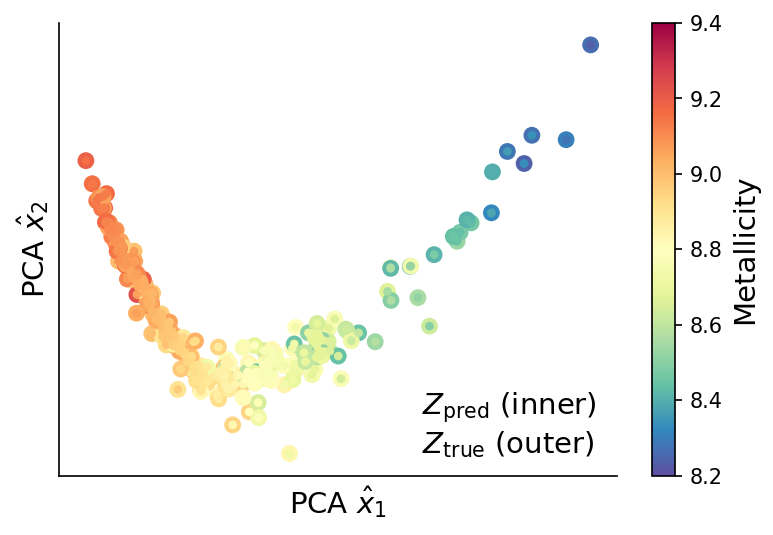

In [101]:
#hide_input
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(acts_PCA[:, 0], acts_PCA[:, 1], s=50, c=Z_trues, vmin=8.2, vmax=9.4, cmap='Spectral_r')
sc = ax.scatter(acts_PCA[:, 0], acts_PCA[:, 1], s=10,  c=Z_preds, vmin=8.2, vmax=9.4, cmap='Spectral_r')

ax.text(0.65, 0.05, r'$Z_{\rm pred}$ (inner)' '\n' r'$Z_{\rm true}$ (outer)', transform=plt.gca().transAxes, fontsize=14)

cb = fig.colorbar(sc)
cb.set_label(r'Metallicity', fontsize=14)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(r'PCA $\hat{x}_1$', fontsize=14)
ax.set_ylabel(r'PCA $\hat{x}_2$', fontsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

It's nice to see that the metallicity varies quite smoothly in this space! However, it's hard to see any details with all these galaxies piled up on top of each other.

>Note: The Nike swoosh curve in the scatter plot is interesting from an astrophysics standpoint. The metallicity appears to be double-valued for PCA $\hat{x}_2$, not dissimilar to the degenerate metallicity solutions from the $R_{23}$ indicator ([Pagel et al. 1979](https://ui.adsabs.harvard.edu/abs/1979MNRAS.189...95P/abstract)). However, this is *not* the cause of the shape here, as $R_{23}$ becomes double-valued at a metallicity of about 8.0, whereas the turnover here is observed at 8.8.

We can also plot the galaxy points using PCA dimension $\hat{x}_3$:

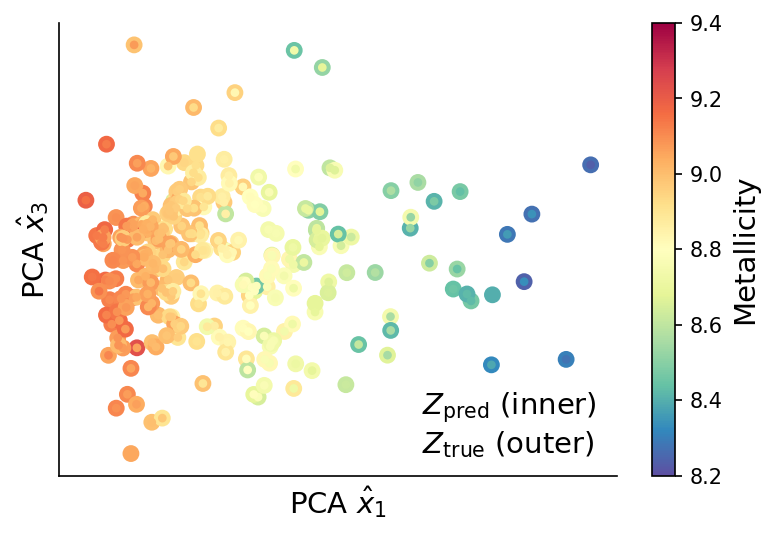

In [66]:
#hide_input
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(acts_PCA[:, 0], acts_PCA[:, 2], s=50, c=Z_trues, vmin=8.2, vmax=9.4, cmap='Spectral_r')
sc = ax.scatter(acts_PCA[:, 0], acts_PCA[:, 2], s=10,  c=Z_preds, vmin=8.2, vmax=9.4, cmap='Spectral_r')

ax.text(0.65, 0.05, r'$Z_{\rm pred}$ (inner)' '\n' r'$Z_{\rm true}$ (outer)', transform=plt.gca().transAxes, fontsize=14)

cb = fig.colorbar(sc)
cb.set_label(r'Metallicity', fontsize=14)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(r'PCA $\hat{x}_1$', fontsize=14)
ax.set_ylabel(r'PCA $\hat{x}_3$', fontsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

Now the points aren't piled up on top of each other, but the metallicity appears to only have a gradient in the PCA $\hat{x}_1$ dimension. 

Finally, rather than representing each galaxy as a colored point, we can display an actual image of the galaxy. Using the `AnnotationBbox` and `OffsetImage` classes in `matplotlib.offsetbox`, we can plop down galaxy images in the scatter plot. We can also color the box around each image according to its metallicity using the `bboxprops` keyword.


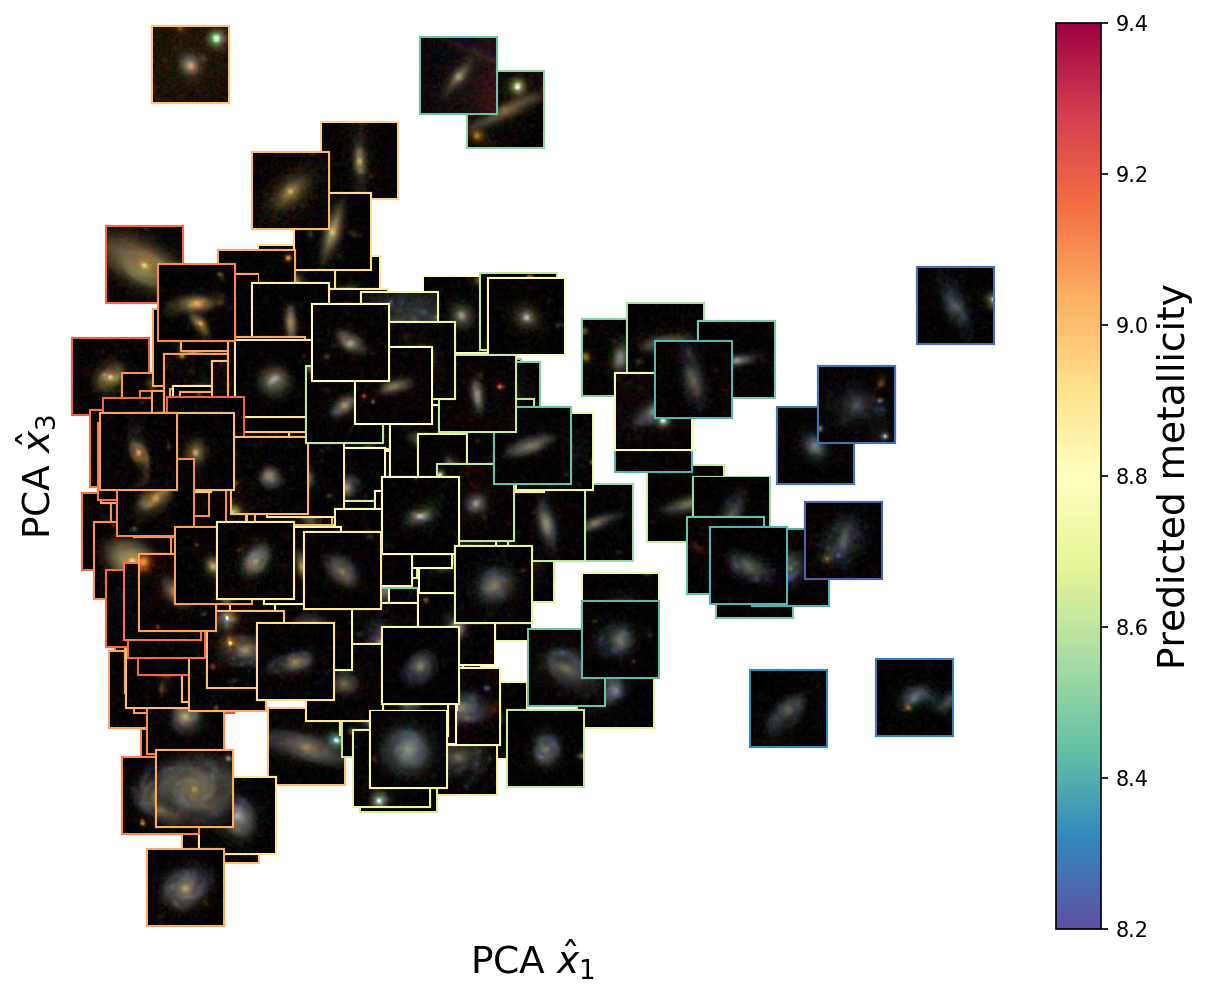

In [80]:
#hide_input
fig = plt.figure(figsize=(10, 8), dpi=150)
ax = fig.add_subplot(1, 1, 1)

sc = ax.scatter(acts_PCA[:, 0], acts_PCA[:, 2], s=10,  c=Z_preds, vmin=8.2, vmax=9.4, cmap='Spectral_r')

artists = []
for objID, pca1, pca3, Z in zip(results.index, acts_PCA[:, 0], acts_PCA[:, 2], Z_trues):
    
    im = CropPad(72)(PILImage.create(f'{ROOT}/images/{objID}.jpg'))
    
    ab = AnnotationBbox(
        OffsetImage(im, zoom=0.5), 
        (pca1, pca3), 
        xycoords='data', 
        frameon=True, 
        pad=0., 
        bboxprops=dict(linewidth=2, edgecolor=plt.cm.Spectral_r((Z-8.2)/1.2))
    )
    artists.append(ax.add_artist(ab))

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(r'PCA $\hat{x}_1$', fontsize=18)
ax.set_ylabel(r'PCA $\hat{x}_3$', fontsize=18)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


cb = plt.colorbar(sc)
cb.set_label(r'Predicted metallicity', fontsize=18)

Now we can really see some morphological stratification of this galaxy subsample! From right to left, it is evident that galaxies have progressively brighter and redder central regions (bulges), and this coincides with a rise in metallicity. In the lower-left corner, galaxies have prominent spiral arms, blue disks, and red bulges. In the upper center portion of this figure, galaxies are mostly inclined (i.e., viewed edge-on).

# Conclusions

Simple methods such as PCA can be powerful for understanding what a neural network has learned. Although we already knew that a trained CNN could robustly predict metallicity, we now can see that it has learned how to distinguish high- and low-metallicity galaxies on the basis of their colors, spiral arms/disks, bulges, and viewing angle. Indeed, we also could have deduced this by simply visualizing the highest and lowest metallicity galaxies, as was shown in the [first blog post](https://jwuphysics.github.io/blog/galaxies/astrophysics/deep%20learning/computer%20vision/2020/05/21/exploring-galaxies-with-deep-learning.html):

![](images/WB19_fig1.jpg)

In Part 2 of this series, we'll continue looking into deep learning visualization techniques. We will be using Gradient-weighted Class Activation Maps, or [Grad-CAM](https://arxiv.org/abs/1610.02391), to localize the image features that a CNN focuses on when it classifies a galaxy as metal-rich or metal-poor.